
## Data Loader for Test Dataset


In [2]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([transforms.Resize((224, 224)), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize((0.485, 0.456, 0.406), 
                                                          (0.229, 0.224, 0.225))])


# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Visualize an example test image, before pre-processing is applied.

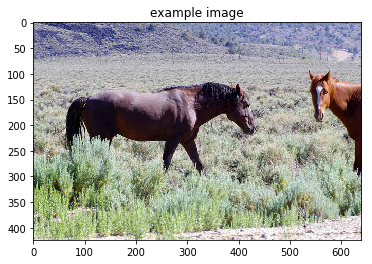

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# Specify the saved models to load.
encoder_file = 'encoder-3.pkl' 
decoder_file = 'decoder-3.pkl'

# #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding): Embedding(9956, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9956, bias=True)
)


## Sampler


In [29]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 80, 13, 1310, 170, 77, 3, 204, 18, 1]



## Captions Cleanup


In [30]:
import re
def clean_sentence(output):
    words = []
    
    for index in output:
        words.append(data_loader.dataset.vocab.idx2word[index])
    
    #Strip <start> and <end>
    words = words[1:-1]
    sentence = ' '.join(map(str, words)).capitalize()
    sentence = re.sub(r'\s([?,.!"](?:\s|$))', r'\1', sentence)
    return sentence

In [31]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A group of horses standing in a field.



## Generate Predictions!

In [9]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

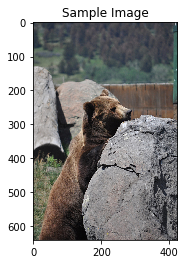

A brown bear standing next to a stone wall.


In [35]:
get_prediction()

### Sample images where the model performed well!

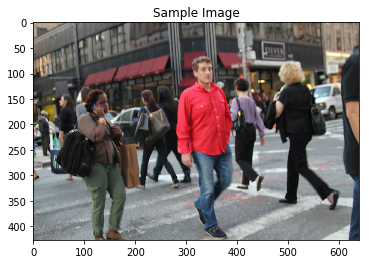

A group of people walking down a street.


In [11]:
get_prediction()

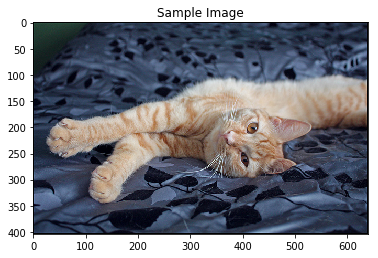

A cat laying on top of a blue blanket.


In [23]:
get_prediction()

### Sample image where the model could have performed better ...

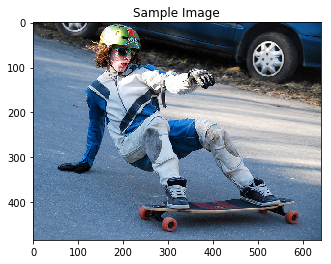

A young boy riding a skateboard on a road.


In [38]:
get_prediction()

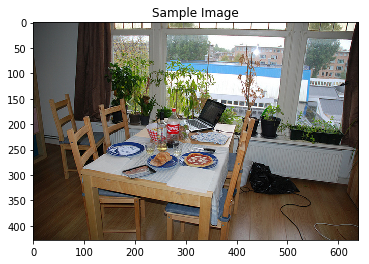

A table with a laptop and a glass of wine.


In [24]:
get_prediction()